# Machine learning on a tabular dataset

Distinguishing Higgs boson (signal) events from events without Higgs.

You have learned to do it with cuts - "linearly".

Now let's try to distinguish the events with a machine learning classifier to increase the signal/background ratio and make the analysis more sensitive.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pickle
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

In [3]:
data = pickle.load(open('htautau.pkl','rb'))

In [4]:
data.keys()

dict_keys(['Run2012B_TauPlusX', 'DYJetsToLL', 'GluGluToHToTauTau', 'TTbar', 'W1JetsToLNu', 'W2JetsToLNu', 'VBF_HToTauTau', 'Run2012C_TauPlusX', 'W3JetsToLNu'])

Let's take a look at one of the datasets - a ttbar simulation. This is a typical background process for many Higgs analyses, because the top quarks can decay into various channels which can fake a Higgs signal.

We have ~36k simulated events, and a number of features for each event.

In [5]:
data["TTbar"].keys()

Index(['njets', 'npv', 'pt_1', 'eta_1', 'phi_1', 'm_1', 'iso_1', 'q_1', 'mt_1',
       'pt_2', 'eta_2', 'phi_2', 'm_2', 'iso_2', 'q_2', 'mt_2', 'dm_2',
       'jpt_1', 'jeta_1', 'jphi_1', 'jm_1', 'jbtag_1', 'jpt_2', 'jeta_2',
       'jphi_2', 'jm_2', 'jbtag_2', 'pt_met', 'phi_met', 'm_vis', 'pt_vis',
       'mjj', 'ptjj', 'jdeta', 'gen_match', 'run', 'weight'],
      dtype='object')

In [6]:
data["TTbar"]

,njets,npv,pt_1,eta_1,phi_1,m_1,iso_1,q_1,mt_1,pt_2,...,pt_met,phi_met,m_vis,pt_vis,mjj,ptjj,jdeta,gen_match,run,weight
entry,,,,,,,,,,,,,,,,,,,,,
0,3,13,28.667351,1.562036,-0.842856,0.105658,0.000000,1,80.909939,36.405731,...,60.111469,2.751014,26.211727,60.862858,130.860291,38.344780,1.321880,False,1,0.402044
1,2,17,76.649849,-0.184059,1.773671,0.105658,0.009272,1,22.561057,28.185574,...,53.055363,1.418015,48.864986,102.870186,471.998077,151.001190,-2.423236,False,1,0.402044
2,5,20,40.108189,1.004245,2.685524,0.105658,0.031531,1,17.254477,20.238079,...,2.037169,-1.062208,60.555405,23.285250,207.719421,24.611734,0.925452,True,1,0.402044
3,2,18,17.215254,-1.608321,0.190183,0.105658,0.042270,-1,42.682263,26.714300,...,65.352066,-1.189085,45.746376,36.980255,139.373489,82.207253,-1.183147,False,1,0.402044
4,6,21,46.573315,-0.950096,2.138021,0.105658,0.057344,1,59.807889,47.802555,...,69.078201,1.027376,96.430687,94.001167,257.197113,101.881531,2.388012,False,1,0.402044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36861,6,22,23.628647,1.839439,1.272713,0.105658,0.132470,1,81.719287,20.719923,...,133.357239,2.903198,12.645602,43.711403,329.632202,46.506054,2.945638,False,1,0.402044
36862,1,13,18.357796,1.270961,2.813488,0.105658,0.027570,-1,64.936889,53.670872,...,96.485214,1.051181,90.164818,46.692497,-999.000000,-999.000000,-999.000000,False,1,0.402044
36863,2,17,52.057220,-0.379592,0.721136,0.105658,0.009719,1,39.442700,66.956032,...,65.936806,0.034499,116.174332,65.213791,88.366661,86.378456,0.057873,False,1,0.402044


Let's pick just two features - $M_{T,1}$ and $M_{T,2}$ at first.

In [7]:
keys = [
    "mt_1",
    "mt_2"
]

In [8]:
data["TTbar"][keys]

,mt_1,mt_2
entry,,
0,80.909939,92.667939
1,22.561057,3.189914
2,17.254477,1.133351
3,42.682263,79.947394
4,59.807889,69.045794
...,...,...
36861,81.719287,63.217953
36862,64.936889,134.028582
36863,39.442700,81.453346


In [9]:
X = torch.Tensor(data['TTbar'][keys].values) # feature matrix (Nevents, Nfeatures) = (~36k, 2)
y = torch.Tensor(np.zeros((len(X), 1), dtype=np.float32)) # target matrix/vector (Nevents, 1) = (~36k, 1)
ds_ttbar = TensorDataset(X,y)
X.shape, y.shape

(torch.Size([36866, 2]), torch.Size([36866, 1]))

In [10]:
X

tensor([[80.9099, 92.6679],
        [22.5611,  3.1899],
        [17.2545,  1.1334],
        ...,
        [39.4427, 81.4533],
        [12.3542, 23.5107],
        [48.8658, 89.9014]])

In [11]:
y

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])

In [12]:
X_ggh = torch.Tensor(data['GluGluToHToTauTau'][keys].values) 
y_ggh = torch.Tensor(np.ones((len(X_ggh), 1), dtype=np.float32)) 
ds_ggh = TensorDataset(X_ggh,y_ggh)
X_ggh.shape, y_ggh.shape

(torch.Size([8085, 2]), torch.Size([8085, 1]))

In [13]:
X_ggh

tensor([[ 12.2097, 103.8012],
        [ 30.5824,  60.9333],
        [ 52.0285,  27.2350],
        ...,
        [  3.6372, 115.7324],
        [  5.8181,  69.7466],
        [ 53.8415,   6.1458]])

In [14]:
y_ggh

tensor([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]])

In [15]:
print(  len(ds_ttbar),
        len(ds_ggh) )

36866 8085


In [16]:
full_dataset = torch.utils.data.ConcatDataset([ds_ttbar, ds_ggh]) # paneme 2 dataseti yksteisega kokku
print('Full dataset', len(full_dataset))

Full dataset 44951


In [17]:
Nev = len(full_dataset)
Nev_half = int(Nev/2)

random_order = np.random.permutation(range(Nev))
random_order

array([ 6826, 35241, 10141, ..., 15388, 44212, 25008])

In [18]:
train_indices = random_order[:Nev_half]
test_indices = random_order[Nev_half:]

In [19]:
train_ds = torch.utils.data.dataset.Subset(full_dataset, train_indices)
test_ds = torch.utils.data.dataset.Subset(full_dataset, test_indices)
print(len(train_ds), len(test_ds))

22475 22476


In [20]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)    # objekt kust saab kysida juppe
test_loader = DataLoader(test_ds, batch_size=32, shuffle=True)

In [21]:
"""plt.figure(figsize=(5,5))

idx_mt_1 = keys.index('mt_1')
idx_mt_2 = keys.index('mt_2')
plt.scatter(ds_ttbar.tensors[0][:1000], ds_ttbar.tensors)"""

"plt.figure(figsize=(5,5))\n\nidx_mt_1 = keys.index('mt_1')\nidx_mt_2 = keys.index('mt_2')\nplt.scatter(ds_ttbar.tensors[0][:1000], ds_ttbar.tensors)"

In [22]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):               # In a nutshell, genereerib meie narvivorgu
    def __init__(self, input_dim):
        super().__init__()

        hidden_dim = 256    # hyperparameeter

        self.lin1 = nn.Linear(input_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, 1)
        self.act = torch.nn.ELU()

    def forward(self, x):
        #x: (32, 2) matrix
        x = self.act(self.lin1(x))

        #x: (32, 256) matrix
        x = self.act(self.lin2(x))

        #: (32, 1) matrix
        x = torch.sigmoid(x)    # olemas ka muid nagu RELU
        return x

net = Net(len(keys))

In [23]:
x = torch.Tensor([0.1, 100.0])
net(x) # grad_fn tahendab tuletist

tensor([0.9994], grad_fn=<SigmoidBackward0>)

In [24]:
net.lin1.bias.shape

torch.Size([256])

In [25]:
net.lin1.weight.shape

torch.Size([256, 2])

In [26]:
net.lin1.bias

Parameter containing:
tensor([ 0.4832,  0.2637, -0.6186,  0.4827,  0.6569, -0.0224,  0.0982, -0.3689,
         0.0437, -0.7041, -0.2698, -0.1723,  0.5004,  0.4931,  0.3295,  0.0592,
        -0.5680, -0.0038,  0.7052, -0.3907, -0.1405,  0.3298, -0.1729,  0.3494,
        -0.4882,  0.4322, -0.3957, -0.2203,  0.1047, -0.6104, -0.6948, -0.6886,
        -0.0172, -0.2346, -0.5204, -0.4148,  0.3773,  0.6938,  0.5141,  0.0929,
        -0.4924, -0.5011,  0.3028,  0.6066, -0.4831, -0.5179,  0.1110,  0.0307,
        -0.1989, -0.6581,  0.2604, -0.0928,  0.2618, -0.0423,  0.0030,  0.6863,
         0.3376,  0.4333, -0.3000,  0.1829,  0.4009, -0.6369, -0.5683,  0.1740,
        -0.4591, -0.1812,  0.5801, -0.4648,  0.3322,  0.0682, -0.6966, -0.5505,
         0.0860, -0.1992,  0.2590,  0.5185,  0.6472,  0.2434,  0.5042,  0.5625,
        -0.3994,  0.2593,  0.6611, -0.2229,  0.2637,  0.5855, -0.3678,  0.0513,
        -0.0441, -0.2807, -0.3427, -0.4298,  0.3120,  0.3610,  0.0729, -0.2368,
         0.5008, -

In [27]:
net.lin1.weight


Parameter containing:
tensor([[ 0.0756, -0.6790],
        [-0.5791,  0.4398],
        [-0.3666, -0.2434],
        [ 0.5918, -0.0065],
        [ 0.0167,  0.3294],
        [-0.5601,  0.0992],
        [ 0.3406,  0.1554],
        [ 0.6454,  0.2965],
        [-0.5506,  0.3924],
        [ 0.5873, -0.0473],
        [ 0.3917, -0.0565],
        [-0.2571, -0.6379],
        [ 0.6948, -0.0181],
        [ 0.0639, -0.2800],
        [-0.0735, -0.1471],
        [-0.3879,  0.5538],
        [-0.2380,  0.4289],
        [-0.5699, -0.3321],
        [ 0.0902, -0.1607],
        [ 0.6027,  0.5499],
        [ 0.2500,  0.6647],
        [ 0.1218,  0.1878],
        [-0.1821, -0.4877],
        [ 0.6253, -0.2515],
        [-0.6492, -0.2406],
        [-0.5857, -0.1969],
        [-0.5237, -0.4030],
        [ 0.3743, -0.6134],
        [-0.3611,  0.5305],
        [-0.3604,  0.1930],
        [-0.1829,  0.2955],
        [-0.2277,  0.1457],
        [-0.6414, -0.2960],
        [-0.4429,  0.7062],
        [ 0.4202, -0.6456]

In [28]:
# kuidas 
"""vals_mt = torch.Tensor(np.linspace(0,100,100))"""

'vals_mt = torch.Tensor(np.linspace(0,100,100))'

In [29]:
import torch.optim as optim

criterion = nn.BCELoss(reduction='none')    # teha valeseid otsuseid on kallis
optimizer = optim.Adam(net.parameters(), lr = 0.0001)

We want to minimize the loss function across predictions $p\in[0,1]$ and labels $y\in\{0, 1\}$ by tuning the model parameters:

$$
L(p,y)
$$

For classification, binary cross-entropy loss:
$$
    L(p,y) = - \left[ y \cdot \log p + (1 - y) \cdot \log (1 - p) \right],
$$

In [30]:
criterion(torch.Tensor([0.99]), torch.Tensor([1.0]))

tensor([0.0101])

In [31]:
criterion(torch.Tensor([0.99]), torch.Tensor([0.0]))


tensor([4.6052])

In [32]:
#evaluate across multible values at the same time
criterion(torch.Tensor([0.99, 0.3]), torch.Tensor([0.0, 1.0]))


tensor([4.6052, 1.2040])

In [33]:
for x in train_loader:
    print(x[0].shape, x[1].shape)
    print(x[0])
    print(x[1])
    break

torch.Size([32, 2]) torch.Size([32, 1])
tensor([[ 17.2938,  15.2590],
        [ 87.1398,  58.6336],
        [121.8535,  66.7665],
        [ 43.7391,  36.1592],
        [ 57.3272, 182.3590],
        [ 75.4667, 242.7202],
        [  3.4457,  17.7163],
        [ 84.1804,  64.6910],
        [ 63.8956,  59.4630],
        [210.5377,  81.9543],
        [ 47.1410,  91.9330],
        [129.9235,  96.8691],
        [ 74.1567,  32.6401],
        [108.3990,  97.1530],
        [ 68.1274,  28.4063],
        [ 87.2468, 106.1255],
        [103.1618,  11.8746],
        [ 72.2994,   7.5891],
        [  3.3243,  45.5888],
        [  1.4774,  54.7309],
        [ 61.5135,  17.6418],
        [ 60.7296,  78.7736],
        [ 48.4054, 117.0736],
        [ 98.5140,  28.9047],
        [144.4447, 123.4635],
        [ 34.8008,  95.7341],
        [120.2934,  91.7504],
        [ 83.0233, 103.1208],
        [130.6484, 146.6804],
        [ 31.3130,  31.6647],
        [ 20.5039,  33.7049],
        [ 80.0245,  59.4602]])

In [34]:
loss_train_vals = []
loss_test_vals = []

for epoch in range(50):  # loop over the dataset multiple times

    loss_train = 0.0
    for i, batch_data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch_data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)
        loss = torch.sum(loss)
        
        loss.backward()
        optimizer.step()

        # print statistics
        loss_train += loss.item()
    
    loss_train_vals.append(loss_train)
    
    loss_test = 0.0
    with torch.no_grad():
        for i, batch_data in enumerate(test_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = batch_data

            # forward
            outputs = net(inputs)

            loss = criterion(outputs, labels)
            loss = torch.sum(loss)

            # print statistics
            loss_test += loss.item()
    loss_test_vals.append(loss_test)

    print("Epoch {}: {:.2f}/{:.2f}".format(epoch, loss_train, loss_test))

Epoch 0: 10674.01/10369.99
Epoch 1: 10438.32/10399.46
Epoch 2: 10446.46/10332.84
Epoch 3: 10412.91/10314.78
Epoch 4: 10410.50/10321.06
Epoch 5: 10409.08/10319.64
Epoch 6: 10429.74/10725.34
Epoch 7: 10392.77/10303.13
Epoch 8: 10394.30/10409.58
Epoch 9: 10407.26/10408.13
Epoch 10: 10404.65/10318.42
Epoch 11: 10406.64/10585.87
Epoch 12: 10412.78/10411.92
Epoch 13: 10405.40/10285.93
Epoch 14: 10380.01/10297.73
Epoch 15: 10392.66/10331.70
Epoch 16: 10352.74/10308.30
Epoch 17: 10407.41/10291.79
Epoch 18: 10389.82/10298.48
Epoch 19: 10372.97/10364.42
Epoch 20: 10378.32/10415.71
Epoch 21: 10358.64/10257.34
Epoch 22: 10347.16/10249.71
Epoch 23: 10387.47/10246.27
Epoch 24: 10359.41/10307.56
Epoch 25: 10348.48/10413.29
Epoch 26: 10320.58/10251.77
Epoch 27: 10328.85/10244.51
Epoch 28: 10328.04/10223.27
Epoch 29: 10308.28/10253.78
Epoch 30: 10324.84/10283.45
Epoch 31: 10298.26/10501.60
Epoch 32: 10305.84/10384.33
Epoch 33: 10311.55/10251.67
Epoch 34: 10312.31/10241.45
Epoch 35: 10315.31/10222.26
Ep

Text(0, 0.5, 'Total loss')

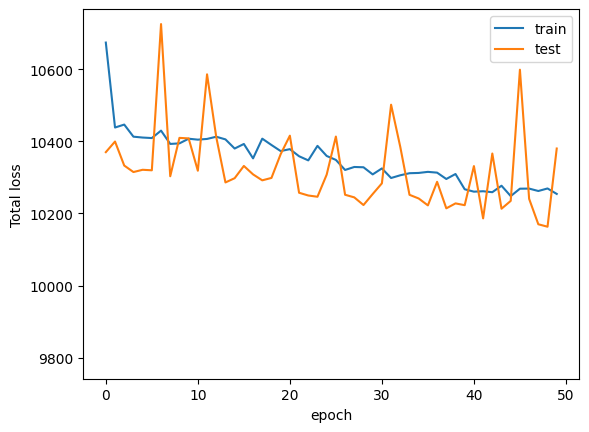

In [35]:
plt.plot(loss_train_vals, label="train")
plt.plot(loss_test_vals, label="test")
plt.ylim(loss_train_vals[-1]*0.95, loss_train_vals[-1]*1.05)
plt.legend()
plt.xlabel("epoch")
plt.ylabel("Total loss")

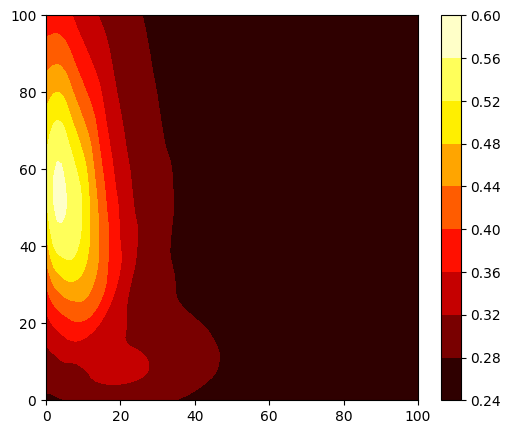

In [36]:
vals_mt = torch.Tensor(np.linspace(0,100,100))

grid_x, grid_y = torch.meshgrid(vals_mt, vals_mt, indexing='ij')
preds = net(torch.stack([grid_x, grid_y], axis=-1)).detach()[:, :, 0]

fig = plt.figure(figsize=(6,5))
ax1 = plt.contourf(grid_x.numpy(), grid_y.numpy(), preds.numpy(), cmap="hot")
plt.colorbar()